**CLASSIFICATION**

In [ ]:
import pandas as pd
df=pd.read_csv('M7.csv')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import numpy as np
import time

def tune_classifiers(X_train, y_train, X_test, y_test, use_random_search=False, cv=5, best_params_dict=None):
    results = {}

    classifiers = {
        "Logistic Regression": (LogisticRegression(max_iter=1000), {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__solver': ['lbfgs', 'liblinear']
        }),
        "Naive Bayes": (GaussianNB(), {}),
        "K-Nearest Neighbors": (KNeighborsClassifier(), {
            'clf__n_neighbors': [3, 5, 7, 11],
            'clf__weights': ['uniform', 'distance']
        }),
        "Decision Tree": (DecisionTreeClassifier(random_state=42), {
            'clf__max_depth': [15, 25, 35],
            'clf__min_samples_split': [2, 5, 10],
            'clf__criterion': ['gini', 'entropy']
        }),
        "Random Forest": (RandomForestClassifier(random_state=42), {
            'clf__n_estimators': [500, 1000],
            'clf__max_depth': [50, None],
            'clf__max_features': ['sqrt', 'log2']
        }),
        "Extra Trees": (ExtraTreesClassifier(random_state=42), {
            'clf__n_estimators': [100, 300],
            'clf__max_depth': [None, 50]
        }),
        "AdaBoost": (AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), random_state=42), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1]
        }),
        "Gradient Boosting": (GradientBoostingClassifier(random_state=42), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 4]
        }),
        "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__max_depth': [3, 4]
        }),
        "LightGBM": (LGBMClassifier(random_state=242), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [15, 31]
        }),
        "Support Vector Machine": (SVC(probability=True, random_state=42), {
            'clf__C': [0.1, 1],
            'clf__gamma': ['scale', 'auto']
        }),
        "Neural Network": (MLPClassifier(max_iter=5000, random_state=42), {
            'clf__hidden_layer_sizes': [(50, 10), (100, 50)],
            'clf__alpha': [0.005, 0.001],
            'clf__learning_rate': ['constant', 'adaptive']
        }),
    }

    for name, (model, param_grid) in classifiers.items():
        print(f"\n🔧 Tuning {name}...")
        model_start = time.time()

        if best_params_dict and name in best_params_dict:
            # Reuse best params
            model_params = {k.replace('clf__', ''): v for k, v in best_params_dict[name].items()}
            model.set_params(**model_params)
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            pipe.fit(X_train, y_train)
            best_model = pipe
            best_params = best_params_dict[name]

        else:
            # Perform tuning
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            if param_grid:  # only tune if params exist
                search = (RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=10,
                                             cv=cv, n_jobs=-1, scoring='accuracy', verbose=0)
                          if use_random_search else
                          GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=0))
                search.fit(X_train, y_train)
                best_model = search.best_estimator_
                best_params = search.best_params_
            else:
                pipe.fit(X_train, y_train)
                best_model = pipe
                best_params = {}

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

        f1 = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else np.nan

        model_end = time.time()
        elapsed_model = model_end - model_start

        print(f"{name} Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, ROC AUC: {roc:.4f}, ⏱ Time: {elapsed_model:.2f} sec")

        results[name] = {
            'accuracy': acc,
            'F1 score': f1,
            'precision': precision,
            'recall': recall,
            'ROC AUC': roc,
            'best_model': best_model,
            'best_params': best_params,
            'time': elapsed_model
        }

    return results


# ---- Load M7 Data ----
df=pd.read_csv('M7.csv')
X = df.drop(columns=["crystal_system"])
y = df["crystal_system"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

runs = 5
aggregated_results = defaultdict(list)
best_param_store = {}

for i in range(runs):
    print(f"\n⏱ Run {i+1} of {runs}...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=242 + i, stratify=y
    )

    if i == 0:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, use_random_search=False, cv=3)
        best_param_store = {model_name: result['best_params'] for model_name, result in run_results.items()}
    else:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, cv=3, best_params_dict=best_param_store)

    for model_name, scores in run_results.items():
        aggregated_results[model_name].append(scores)

# ---- Averaging across runs ----
summary = {}
for model, runs_scores in aggregated_results.items():
    summary[model] = {
        'Avg Accuracy': round(np.mean([r['accuracy'] for r in runs_scores]), 4),
        'Avg F1 Score': round(np.mean([r['F1 score'] for r in runs_scores]), 4),
        'Avg Precision': round(np.mean([r['precision'] for r in runs_scores]), 4),
        'Avg Recall': round(np.mean([r['recall'] for r in runs_scores]), 4),
        'Avg ROC AUC': round(np.nanmean([r['ROC AUC'] for r in runs_scores]), 4),
        'Avg Time (sec)': round(np.mean([r['time'] for r in runs_scores]), 2),
        'Best Params (from first run)': best_param_store[model]
    }

summary_df = pd.DataFrame(summary).T.reset_index().rename(columns={'index': 'Model'})
summary_df.to_csv("Master_V7_Averaged_Results.csv", index=False)

print("\n✅ Averaged results with timings saved to 'MASTER_V7_Averaged_Results.csv'")



⏱ Run 1 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.5379, F1: 0.5251, Precision: 0.5274, Recall: 0.5309, ROC AUC: 0.8539, ⏱ Time: 29.87 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.4446, F1: 0.4299, Precision: 0.4386, Recall: 0.4401, ROC AUC: 0.7991, ⏱ Time: 0.09 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8535, F1: 0.8486, Precision: 0.8559, Recall: 0.8479, ROC AUC: 0.9555, ⏱ Time: 15.20 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8244, F1: 0.8203, Precision: 0.8206, Recall: 0.8205, ROC AUC: 0.8964, ⏱ Time: 31.28 sec

🔧 Tuning Random Forest...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Accuracy: 0.8864, F1: 0.8848, Precision: 0.8873, Recall: 0.8840, ROC AUC: 0.9855, ⏱ Time: 1009.89 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8910, F1: 0.8900, Precision: 0.8922, Recall: 0.8891, ROC AUC: 0.9804, ⏱ Time: 54.94 sec

🔧 Tuning AdaBoost...
AdaBoost Accuracy: 0.5943, F1: 0.5912, Precision: 0.6055, Recall: 0.5907, ROC AUC: 0.8737, ⏱ Time: 242.14 sec

🔧 Tuning Gradient Boosting...
Gradient Boosting Accuracy: 0.8494, F1: 0.8449, Precision: 0.8495, Recall: 0.8452, ROC AUC: 0.9769, ⏱ Time: 3145.60 sec

🔧 Tuning XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:48:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8132, F1: 0.8082, Precision: 0.8155, Recall: 0.8093, ROC AUC: 0.9691, ⏱ Time: 78.08 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6263
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 27
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.888861
[LightGBM] [Info] Start training from score -1.930053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8955, F1: 0.8936, Precision: 0.8963, Recall: 0.8930, ROC AUC: 0.9878, ⏱ Time: 132.07 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.7861, F1: 0.7816, Precision: 0.7934, Recall: 0.7813, ROC AUC: 0.9672, ⏱ Time: 685.51 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.8701, F1: 0.8669, Precision: 0.8700, Recall: 0.8667, ROC AUC: 0.9813, ⏱ Time: 647.25 sec

⏱ Run 2 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.5414, F1: 0.5303, Precision: 0.5333, Recall: 0.5355, ROC AUC: 0.8579, ⏱ Time: 5.99 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.4410, F1: 0.4290, Precision: 0.4387, Recall: 0.4375, ROC AUC: 0.8017, ⏱ Time: 0.08 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8546, F1: 0.8508, Precision: 0.8578, Recall: 0.8495, ROC AUC: 0.9566, ⏱ Time: 1.73 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8180, F1: 0.8144, Precision: 0.8148, Recall: 0.8146, ROC AUC: 0.8943, ⏱ Time

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:21:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8074, F1: 0.8030, Precision: 0.8108, Recall: 0.8034, ROC AUC: 0.9686, ⏱ Time: 5.65 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6260
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 27
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.888861
[LightGBM] [Info] Start training from score -1.930053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8893, F1: 0.8874, Precision: 0.8897, Recall: 0.8869, ROC AUC: 0.9882, ⏱ Time: 11.27 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.7762, F1: 0.7709, Precision: 0.7830, Recall: 0.7714, ROC AUC: 0.9663, ⏱ Time: 87.23 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.8693, F1: 0.8665, Precision: 0.8707, Recall: 0.8665, ROC AUC: 0.9810, ⏱ Time: 63.77 sec

⏱ Run 3 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.5362, F1: 0.5237, Precision: 0.5277, Recall: 0.5292, ROC AUC: 0.8569, ⏱ Time: 7.43 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.4427, F1: 0.4281, Precision: 0.4399, Recall: 0.4398, ROC AUC: 0.8020, ⏱ Time: 0.08 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8573, F1: 0.8525, Precision: 0.8583, Recall: 0.8515, ROC AUC: 0.9571, ⏱ Time: 1.28 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8233, F1: 0.8193, Precision: 0.8192, Recall: 0.8198, ROC AUC: 0.8963, ⏱ Time: 1

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:32:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8118, F1: 0.8065, Precision: 0.8137, Recall: 0.8076, ROC AUC: 0.9712, ⏱ Time: 7.46 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6255
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 27
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.888861
[LightGBM] [Info] Start training from score -1.930053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8962, F1: 0.8939, Precision: 0.8960, Recall: 0.8937, ROC AUC: 0.9881, ⏱ Time: 11.29 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.7818, F1: 0.7761, Precision: 0.7864, Recall: 0.7764, ROC AUC: 0.9687, ⏱ Time: 91.24 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.8767, F1: 0.8738, Precision: 0.8772, Recall: 0.8728, ROC AUC: 0.9813, ⏱ Time: 71.59 sec

⏱ Run 4 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.5288, F1: 0.5148, Precision: 0.5174, Recall: 0.5214, ROC AUC: 0.8525, ⏱ Time: 8.55 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.4398, F1: 0.4254, Precision: 0.4358, Recall: 0.4352, ROC AUC: 0.7990, ⏱ Time: 0.09 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8593, F1: 0.8553, Precision: 0.8606, Recall: 0.8542, ROC AUC: 0.9573, ⏱ Time: 1.27 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8167, F1: 0.8133, Precision: 0.8133, Recall: 0.8135, ROC AUC: 0.8929, ⏱ Time: 1

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:43:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8167, F1: 0.8115, Precision: 0.8182, Recall: 0.8125, ROC AUC: 0.9692, ⏱ Time: 7.41 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6258
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 27
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.888861
[LightGBM] [Info] Start training from score -1.930053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8945, F1: 0.8926, Precision: 0.8949, Recall: 0.8923, ROC AUC: 0.9877, ⏱ Time: 10.92 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.7782, F1: 0.7725, Precision: 0.7851, Recall: 0.7729, ROC AUC: 0.9663, ⏱ Time: 90.45 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.8649, F1: 0.8624, Precision: 0.8642, Recall: 0.8622, ROC AUC: 0.9804, ⏱ Time: 62.47 sec

⏱ Run 5 of 5...

🔧 Tuning Logistic Regression...
Logistic Regression Accuracy: 0.5246, F1: 0.5124, Precision: 0.5152, Recall: 0.5179, ROC AUC: 0.8494, ⏱ Time: 8.74 sec

🔧 Tuning Naive Bayes...
Naive Bayes Accuracy: 0.4328, F1: 0.4202, Precision: 0.4282, Recall: 0.4287, ROC AUC: 0.7961, ⏱ Time: 0.07 sec

🔧 Tuning K-Nearest Neighbors...
K-Nearest Neighbors Accuracy: 0.8579, F1: 0.8535, Precision: 0.8595, Recall: 0.8525, ROC AUC: 0.9584, ⏱ Time: 1.29 sec

🔧 Tuning Decision Tree...
Decision Tree Accuracy: 0.8231, F1: 0.8197, Precision: 0.8202, Recall: 0.8195, ROC AUC: 0.8972, ⏱ Time: 1

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:54:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8097, F1: 0.8055, Precision: 0.8130, Recall: 0.8053, ROC AUC: 0.9692, ⏱ Time: 7.33 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6256
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 27
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.888861
[LightGBM] [Info] Start training from score -1.930053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8986, F1: 0.8966, Precision: 0.8986, Recall: 0.8958, ROC AUC: 0.9882, ⏱ Time: 11.26 sec

🔧 Tuning Support Vector Machine...
Support Vector Machine Accuracy: 0.7729, F1: 0.7681, Precision: 0.7802, Recall: 0.7676, ROC AUC: 0.9640, ⏱ Time: 91.20 sec

🔧 Tuning Neural Network...
Neural Network Accuracy: 0.8684, F1: 0.8642, Precision: 0.8688, Recall: 0.8640, ROC AUC: 0.9803, ⏱ Time: 66.67 sec

✅ Averaged results with timings saved to 'MASTER_V7_Averaged_Results.csv'


**SHAP ANALYSIS**

In [ ]:
import pandas as pd
import numpy as np
import os
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgb

# --- Load data ---
df = pd.read_csv('M7.csv')
target_column = 'crystal_system'

# Encode categorical features except target
for col in df.select_dtypes(include=['object']).columns:
    if col != target_column:
        df[col] = LabelEncoder().fit_transform(df[col])

# Prepare features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Store original class names
class_names = list(np.unique(y))

# Encode target if object
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Models dictionary in order: RF, ET, LGBM
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "ExtraTrees": ExtraTreesClassifier(random_state=42, n_jobs=-1),
    "LGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1)
}

# Output directory
output_dir = "shap_outputs"
os.makedirs(output_dir, exist_ok=True)

# Container for combined SHAP importances
combined_shap_df = pd.DataFrame({"Feature": X_test.columns})

# Loop through models
for model_name, model in models.items():
    print(f"\n🔹 {model_name} 🔹")
    start_time = time.time()

    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # SHAP analysis
    print("Generating SHAP values...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Handle SHAP output shapes
    if isinstance(shap_values, list):
        shap_array = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
        shap_array = np.mean(np.abs(shap_values), axis=2)
    else:
        shap_array = np.abs(shap_values)

    # Mean importance per feature
    mean_importance = np.mean(shap_array, axis=0)
    feature_importance_df = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": mean_importance
    }).sort_values(by="Importance", ascending=False)

    # Save CSV per model
    csv_path = os.path.join(output_dir, f"{model_name}_shap_importance.csv")
    feature_importance_df.to_csv(csv_path, index=False, float_format="%.6f")
    print(f"🔸 Saved: {csv_path}")

    # Top 10 features for SHAP summary plot
    top10_features = feature_importance_df.head(10)["Feature"].tolist()
    X_test_top10 = X_test[top10_features]

    # Adjust SHAP values for top10
    if isinstance(shap_values, list):
        shap_values_top10 = [sv[:, [X_test.columns.get_loc(f) for f in top10_features]] for sv in shap_values]
    else:
        shap_values_top10 = shap_values[:, [X_test.columns.get_loc(f) for f in top10_features]]

    # Plot SHAP summary bar
    plt.figure()
    shap.summary_plot(
        shap_values_top10,
        X_test_top10,
        plot_type="bar",
        show=False,
        class_names=class_names
    )
    plt.title(f"{model_name}")
    plt.gca().set_xlabel("")
    plt.tight_layout()
    plot_path = os.path.join(output_dir, f"{model_name}_shap_top10_plot.png")
    plt.savefig(plot_path, bbox_inches="tight", dpi=400)
    plt.close()

    # Add importance to combined dataframe
    combined_shap_df[model_name] = mean_importance

    elapsed = time.time() - start_time
    print(f"⏱ Time taken: {elapsed:.2f} seconds")

# Save combined SHAP importances CSV
combined_csv_path = os.path.join(output_dir, "Combined_SHAP_importance_M7.csv")
combined_shap_df.to_csv(combined_csv_path, index=False, float_format="%.6f")
print(f"\n✅ Combined SHAP importances saved: {combined_csv_path}")



🔹 RF 🔹
Accuracy: 0.89
Generating SHAP values...
🔸 Saved: shap_outputs/RF_shap_importance.csv
⏱ Time taken: 1592.70 seconds

🔹 ET 🔹
Accuracy: 0.89
Generating SHAP values...
🔸 Saved: shap_outputs/ET_shap_importance.csv
⏱ Time taken: 4112.93 seconds

🔹 LGBM 🔹
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6254
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 27
[LightGBM] [Info] Start training from score -2.074334
[LightGBM] [Info] Start training from score -1.891258
[LightGBM] [Info] Start training from score -1.902982
[LightGBM] [Info] Start training from score -2.037951
[LightGBM] [Info] Start training from score -1.901249
[LightGBM] [Info] Start training from score -1.895380
[LightGBM] [Info] Start training from score -1.935055
Accuracy: 0.89
Generating SHAP values...
🔸 Saved: shap_outputs/LGBM_shap_im

/tmp/ipython-input-2395812958.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


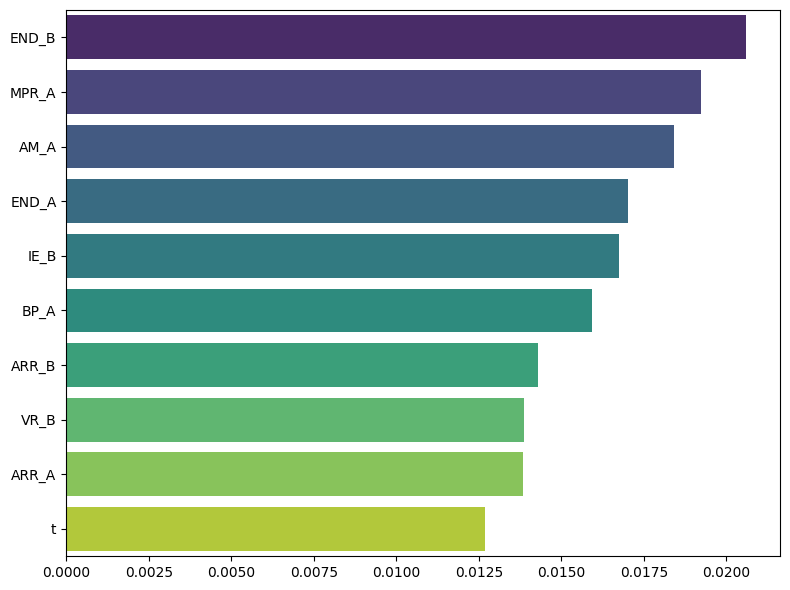

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv('Combined_SHAP_importance_M7.csv')

# Adjust LightGBM values
df["LGBM"] = df["LGBM"] / 10

# Recalculate Mean Importance
df["Mean Importance"] = df[["RandomForest", "ExtraTrees", "LGBM"]].mean(axis=1)

# Sort by Mean Importance and take top 10
top10 = df.sort_values("Mean Importance", ascending=False).head(10)

# Plot top 10 features
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top10,
    y="Feature",
    x="Mean Importance",
    palette="viridis"
)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig("top10_features_M7.png", dpi=400)
plt.show()
plt.close()


**Classification with reduced features**

In [1]:
import pandas as pd
df=pd.read_csv('M7.csv')

In [2]:
#Features to keep
features = ["END_B", "MPR_A", "AM_A","END_A", "IE_B", "BP_A","ARR_B", "VR_B", "ARR_A","t","crystal_system"]
df = df[features]
df.columns

Index(['END_B', 'MPR_A', 'AM_A', 'END_A', 'IE_B', 'BP_A', 'ARR_B', 'VR_B',
       'ARR_A', 't', 'crystal_system'],
      dtype='object')

In [3]:
# ---------------- Classification: RF, ET, LGBM only ----------------
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from collections import defaultdict
import numpy as np
import time

def tune_classifiers(X_train, y_train, X_test, y_test, cv=3, best_params_dict=None):
    results = {}

    classifiers = {
        "Random Forest": (RandomForestClassifier(random_state=42), {
            'clf__n_estimators': [500, 1000],
            'clf__max_depth': [50, None],
            'clf__max_features': ['sqrt', 'log2']
        }),
        "Extra Trees": (ExtraTreesClassifier(random_state=42), {
            'clf__n_estimators': [100, 300],
            'clf__max_depth': [None, 50]
        }),
        "LightGBM": (LGBMClassifier(random_state=242), {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.05, 0.1],
            'clf__num_leaves': [15, 31]
        })
    }

    for name, (model, param_grid) in classifiers.items():
        print(f"\n🔧 Tuning {name}...")
        start = time.time()

        if best_params_dict and name in best_params_dict:
            # Reuse best params
            model_params = {k.replace('clf__', ''): v for k, v in best_params_dict[name].items()}
            model.set_params(**model_params)
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            pipe.fit(X_train, y_train)
            best_model = pipe
            best_params = best_params_dict[name]
        else:
            # Tune with GridSearch
            pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
            search = GridSearchCV(pipe, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=0)
            search.fit(X_train, y_train)
            best_model = search.best_estimator_
            best_params = search.best_params_

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test) if hasattr(best_model, "predict_proba") else None

        f1 = f1_score(y_test, y_pred, average='macro')
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        roc = roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else np.nan

        elapsed = time.time() - start

        print(f"{name} Accuracy: {acc:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, ROC AUC: {roc:.4f}, ⏱ {elapsed:.2f} sec")

        results[name] = {
            'accuracy': acc,
            'F1 score': f1,
            'precision': precision,
            'recall': recall,
            'ROC AUC': roc,
            'best_model': best_model,
            'best_params': best_params,
            'time': elapsed
        }

    return results


X = df.drop(columns=["crystal_system"])
y = df["crystal_system"]

if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Repeated Runs ----
runs = 5
aggregated_results = defaultdict(list)
best_param_store = {}

for i in range(runs):
    print(f"\n⏱ Run {i+1} of {runs}...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=242 + i, stratify=y
    )

    if i == 0:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, cv=3)
        best_param_store = {model_name: result['best_params'] for model_name, result in run_results.items()}
    else:
        run_results = tune_classifiers(X_train, y_train, X_test, y_test, cv=3, best_params_dict=best_param_store)

    for model_name, scores in run_results.items():
        aggregated_results[model_name].append(scores)

# ---- Averaging results ----
summary = {}
for model, runs_scores in aggregated_results.items():
    summary[model] = {
        'Avg Accuracy': round(np.mean([r['accuracy'] for r in runs_scores]), 4),
        'Avg F1 Score': round(np.mean([r['F1 score'] for r in runs_scores]), 4),
        'Avg Precision': round(np.mean([r['precision'] for r in runs_scores]), 4),
        'Avg Recall': round(np.mean([r['recall'] for r in runs_scores]), 4),
        'Avg ROC AUC': round(np.nanmean([r['ROC AUC'] for r in runs_scores]), 4),
        'Avg Time (sec)': round(np.mean([r['time'] for r in runs_scores]), 2),
        'Best Params (from first run)': best_param_store[model]
    }

summary_df = pd.DataFrame(summary).T.reset_index().rename(columns={'index': 'Model'})
summary_df.to_csv("M7_reduced_results.csv", index=False)


⏱ Run 1 of 5...

🔧 Tuning Random Forest...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest Accuracy: 0.8724, F1: 0.8700, Precision: 0.8728, Recall: 0.8695, ROC AUC: 0.9817, ⏱ 878.51 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8759, F1: 0.8738, Precision: 0.8765, Recall: 0.8733, ROC AUC: 0.9776, ⏱ 47.79 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 10
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.888861
[LightGBM] [Info] Start training from score -1.930053


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8740, F1: 0.8712, Precision: 0.8742, Recall: 0.8710, ROC AUC: 0.9830, ⏱ 71.44 sec

⏱ Run 2 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8637, F1: 0.8614, Precision: 0.8637, Recall: 0.8608, ROC AUC: 0.9813, ⏱ 86.89 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8742, F1: 0.8725, Precision: 0.8750, Recall: 0.8717, ROC AUC: 0.9776, ⏱ 8.90 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2455
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 10
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8666, F1: 0.8645, Precision: 0.8676, Recall: 0.8640, ROC AUC: 0.9822, ⏱ 5.75 sec

⏱ Run 3 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8705, F1: 0.8673, Precision: 0.8690, Recall: 0.8675, ROC AUC: 0.9803, ⏱ 87.51 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8763, F1: 0.8735, Precision: 0.8750, Recall: 0.8737, ROC AUC: 0.9776, ⏱ 9.01 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2453
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 10
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training fr

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8740, F1: 0.8710, Precision: 0.8733, Recall: 0.8714, ROC AUC: 0.9828, ⏱ 5.83 sec

⏱ Run 4 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8736, F1: 0.8711, Precision: 0.8736, Recall: 0.8706, ROC AUC: 0.9808, ⏱ 91.85 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8746, F1: 0.8725, Precision: 0.8749, Recall: 0.8721, ROC AUC: 0.9767, ⏱ 12.30 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2454
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 10
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8703, F1: 0.8675, Precision: 0.8703, Recall: 0.8675, ROC AUC: 0.9835, ⏱ 7.58 sec

⏱ Run 5 of 5...

🔧 Tuning Random Forest...
Random Forest Accuracy: 0.8734, F1: 0.8706, Precision: 0.8726, Recall: 0.8702, ROC AUC: 0.9817, ⏱ 95.03 sec

🔧 Tuning Extra Trees...
Extra Trees Accuracy: 0.8755, F1: 0.8731, Precision: 0.8752, Recall: 0.8727, ROC AUC: 0.9769, ⏱ 10.47 sec

🔧 Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2451
[LightGBM] [Info] Number of data points in the train set: 19333, number of used features: 10
[LightGBM] [Info] Start training from score -2.074746
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training from score -1.908547
[LightGBM] [Info] Start training from score -2.043924
[LightGBM] [Info] Start training from score -1.896413
[LightGBM] [Info] Start training f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM Accuracy: 0.8680, F1: 0.8654, Precision: 0.8676, Recall: 0.8650, ROC AUC: 0.9840, ⏱ 6.28 sec
